# Add title

## Import libraries

In [1]:
import numpy as np
import plaidml.keras
import os
plaidml.keras.install_backend()
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

from keras import backend as K
print(K)

import keras
from keras.preprocessing.image import ImageDataGenerator

print("Keras version %s" %keras.__version__)

<module 'plaidml.keras.backend' from 'E:\\anaconda3\\envs\\plaidML\\lib\\site-packages\\plaidml\\keras\\backend.py'>
Keras version 2.2.4


## Load meta file (onset, offset, labels)

In [2]:
import pandas as pd
df = pd.read_csv('E:\\Xception\\TUT-SED-synthetic-2016\\meta.txt', delimiter = "\t", header=None)
df.columns = ["file", "drop1", "onset", "offset", "label", "drop2"]
df = df.drop(columns=["drop1", "drop2"])

## Extract Features

In [3]:
# Load various imports 
import pandas as pd
import librosa.display
import librosa

directory = 'E:\\Xception\\TUT-SED-synthetic-2016\\audio\\'

max_pad_len = 0    

features = []

# Iterate through each sound file and extract the features 
for i in range(100):
    
    if i%10==0:
        print("processing element ",i)
    
    file_name = directory+'TUT-SED-synthetic-2016-mix-'+str(i)+'.wav'
    
    #print(file_name)
    
    # extract metadata of single audio file
    audio, sr = librosa.load(file_name, res_type='kaiser_fast')
    
    #mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40, n_fft=440, hop_length=73, n_mels=40)
    #mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    #mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_fft=1024, hop_length=882, n_mels=40)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40, n_fft=440, hop_length=220, n_mels=40)
    
    features.append([mfccs])


processing element  0
processing element  10
processing element  20
processing element  30
processing element  40
processing element  50
processing element  60
processing element  70
processing element  80
processing element  90


## Data labelling

In [4]:
#labelling matrix creation

import numpy as np

num_classes = df['label'].nunique()
labels = []

label_switch = {"alarms_and_sirens" : 0,
                "baby_crying" : 1,
                "bird_singing" : 2,
                "bus" : 3,
                "cat_meowing" : 4,
                "crowd_applause" : 5,
                "crowd_cheering" : 6,
                "dog_barking" : 7,
                "footsteps" : 8,
                "glass_smash" : 9,
                "gun_shot" : 10,
                "horsewalk" : 11,
                "mixer" : 12,
                "motorcycle" : 13,
                "rain" : 14,
                "thunder" : 15,        
}


for i in range(100):
    
    if i%10==0:
        print("processing element ",i)
        
    file_name = directory+'TUT-SED-synthetic-2016-mix-'+str(i)+'.wav'

    #initialize matrix with zeros
    num_frames = np.vstack(features[i]).shape[1]
    single_labels = np.zeros((num_classes, num_frames), dtype=int)

    # extract metadata of single audio file
    query_name = file_name[len('E:\\Xception\\TUT-SED-synthetic-2016\\audio\\'):]
    query_name = 'audio/' + query_name
    subdf = df.query('file==@query_name')

    #populate matrix based on meta file
    for index, row in subdf.iterrows():
        start = int(row['onset']*100)
        #print(start)
        end = int(row['offset']*100)
        #print(start, end)
        for i in range(end-start):
            single_labels[label_switch[row['label']]][i+start] = 1
        #for x in labels:
        #    for y in x:
                #print(y)
            
    labels.append([single_labels])


processing element  0
processing element  10
processing element  20
processing element  30
processing element  40
processing element  50
processing element  60
processing element  70
processing element  80
processing element  90


## Create subvectors for each mixture

In [5]:
# create data structures to contain data
splitted_features = []
splitted_labels =[]

for i in range(100):
    
    if i%10==0:
        print("processing element ",i)
    
    # extract working features and labels
    working_f = np.vstack(features[i])
    working_l = np.vstack(labels[i])
    
    for j in range(int(working_f.shape[1]/1024)+1):
        
        # subdivide in 1024 elements vectors
        feat = working_f[:,j*1024:(j+1)*1024]
        lab = working_l[:,j*1024:(j+1)*1024]
        
        # last vector need padding
        if feat.shape[1] != 1024:
            feat = np.pad(feat, pad_width=((0, 0), (0, 1024-feat.shape[1])), mode='constant')
            lab = np.pad(lab, pad_width=((0, 0), (0, 1024-lab.shape[1])), mode='constant')
        
        splitted_features.append(feat)
        splitted_labels.append(lab)


processing element  0
processing element  10
processing element  20
processing element  30
processing element  40
processing element  50
processing element  60
processing element  70
processing element  80
processing element  90


## Create dataframe to manipulate features and labels

In [6]:
# create empty data frame in pandas
dataframe = pd.DataFrame()

# add features
dataframe['feature']  = splitted_features

# add labels
dataframe['class_label']  = splitted_labels

print('Total dataset contains', len(dataframe), ' files')

Total dataset contains 3376  files


## Preprocess data to input the network 

In [7]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(dataframe.feature.tolist())
y = np.array(dataframe.class_label.tolist())

# Encode the classification labels
#le = LabelEncoder()
#yy = to_categorical(le.fit_transform(y)) 

# delete dataframe to save memory
#reset_selective -f featuresdf

# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

# delete X to save memory
#reset_selective -f X

3376

## Load meta file (onset, offset, labels)

In [17]:
import pandas as pd
df = pd.read_csv('E:\\Xception\\TUT-SED-synthetic-2016\\meta.txt', delimiter = "\t", header=None)
#df.drop(columns=[1, 5])
df.columns = ["file", "drop1", "onset", "offset", "label", "drop2"]
df = df.drop(columns=["drop1", "drop2"])
df

,file,onset,offset,label
0,audio/TUT-SED-synthetic-2016-mix-0.wav,2.82,2.90,horsewalk
1,audio/TUT-SED-synthetic-2016-mix-0.wav,3.08,3.16,horsewalk
2,audio/TUT-SED-synthetic-2016-mix-0.wav,3.32,3.44,horsewalk
3,audio/TUT-SED-synthetic-2016-mix-0.wav,3.62,3.72,horsewalk
4,audio/TUT-SED-synthetic-2016-mix-0.wav,3.82,3.96,horsewalk
...,...,...,...,...
36321,audio/TUT-SED-synthetic-2016-mix-9.wav,311.38,311.52,bird_singing
36322,audio/TUT-SED-synthetic-2016-mix-9.wav,334.86,335.00,bird_singing
36323,audio/TUT-SED-synthetic-2016-mix-9.wav,335.22,335.74,bird_singing
36324,audio/TUT-SED-synthetic-2016-mix-9.wav,335.82,336.28,bird_singing


## Load data, split sounds and extract features

In [18]:
# Load various imports 
import pandas as pd
import librosa

directory = 'E:\\Xception\\TUT-SED-synthetic-2016\\audio\\'

max_pad_len = 0    

features = []

# Iterate through each sound file and extract the features 
for i in range(100):
    
    if i%10==0:
        print("processing element ",i)
    
    file_name = directory+'TUT-SED-synthetic-2016-mix-'+str(i)+'.wav'
    
    print(file_name)
    
    # extract metadata of single audio file
    audio, sr = librosa.load(file_name, res_type='kaiser_fast')
    query_name = file_name[len('E:\\Xception\\TUT-SED-synthetic-2016\\audio\\'):]
    query_name = 'audio/' + query_name
    subdf = df.query('file==@query_name')
        
    # split subsounds and extract features of each subfile
    for index, row in subdf.iterrows():
        mfccs = librosa.feature.mfcc(y=audio[int(sr*row['onset']):int(sr*row['offset'])], sr=sr, n_mfcc=40, n_fft=440, hop_length=73)
        
        #compute maximum pad length needed
        num_frames = mfccs.shape[1]
        # Update frames maximum
        if (num_frames > max_pad_len):
            max_pad_len = num_frames
        
        # add extracted features to list
        features.append([mfccs, row['label']])

# pad data since they have different length
for i in range(len(features)):
    
    pad_width = max_pad_len - features[i][0].shape[1]
    features[i][0] = np.pad(features[i][0], pad_width=((0, 0), (0, pad_width)), mode='constant')
    
# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files')

processing element  0
E:\Xception\TUT-SED-synthetic-2016\audio\TUT-SED-synthetic-2016-mix-0.wav
E:\Xception\TUT-SED-synthetic-2016\audio\TUT-SED-synthetic-2016-mix-1.wav
E:\Xception\TUT-SED-synthetic-2016\audio\TUT-SED-synthetic-2016-mix-2.wav
E:\Xception\TUT-SED-synthetic-2016\audio\TUT-SED-synthetic-2016-mix-3.wav
E:\Xception\TUT-SED-synthetic-2016\audio\TUT-SED-synthetic-2016-mix-4.wav
E:\Xception\TUT-SED-synthetic-2016\audio\TUT-SED-synthetic-2016-mix-5.wav
E:\Xception\TUT-SED-synthetic-2016\audio\TUT-SED-synthetic-2016-mix-6.wav
E:\Xception\TUT-SED-synthetic-2016\audio\TUT-SED-synthetic-2016-mix-7.wav
E:\Xception\TUT-SED-synthetic-2016\audio\TUT-SED-synthetic-2016-mix-8.wav
E:\Xception\TUT-SED-synthetic-2016\audio\TUT-SED-synthetic-2016-mix-9.wav
processing element  10
E:\Xception\TUT-SED-synthetic-2016\audio\TUT-SED-synthetic-2016-mix-10.wav
E:\Xception\TUT-SED-synthetic-2016\audio\TUT-SED-synthetic-2016-mix-11.wav
E:\Xception\TUT-SED-synthetic-2016\audio\TUT-SED-synthetic-2016-m

## Save processed data to pickle file

In [19]:
featuresdf.to_pickle('E:\\Xception\\TUT-SED-synthetic-2016\\processed_data_frame.pkl')
# delete data structure to save ram space (reload dataframe with next block)
reset_selective -f features

## Load processed data to pikle file

In [1]:
import pandas as pd
featuresdf = pd.read_pickle('E:\\Xception\\TUT-SED-synthetic-2016\\processed_data_frame.pkl')

## Preprocess data

In [39]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

# delete dataframe to save memory
reset_selective -f featuresdf

# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

# delete X to save memory
reset_selective -f X

SyntaxError: invalid syntax (<ipython-input-39-3c718a12eba0>, line 13)

## Model definition

In [13]:
from keras.models import Model
from keras.layers import SeparableConv2D, ZeroPadding2D, Activation, Dropout, Dense, \
                            Conv2D, MaxPooling2D, GlobalAveragePooling2D, Reshape
from keras.layers.normalization import BatchNormalization
from keras import Input, optimizers

num_rows = 40
num_columns = 1024
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_columns, num_rows, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_columns, num_rows, num_channels)

#num_labels = yy.shape[1]
num_labels = 16

def Net(input_shape, num_classes, dilated_kernel, dilation, dilated_padding):
    
    # input layer
    inputs = Input(shape=(num_columns, num_rows, num_channels))
    
    # DWS-CNN layer 1
    x = ZeroPadding2D(padding=(2))(inputs)
    # use valid padding since padding is introduced before since it has a special form
    x = SeparableConv2D(256,kernel_size=(5,5), strides=(1,1), padding='valid')(x)
    x = Activation('relu')(x)
    # Batch Normalisation before passing it to the next layer
    x = BatchNormalization()(x)
    # Pooling
    x = MaxPooling2D(pool_size=(1,5), strides=(1,5), padding='valid')(x)
    # Dropout
    x = Dropout(0.25)(x)
    
    # DWS-CNN layer 2
    x = ZeroPadding2D(padding=(2))(x)
    # use valid padding since padding is introduced before since it has a special form
    x = SeparableConv2D(256,kernel_size=(5,5), strides=(1,1), padding='valid')(x)
    x = Activation('relu')(x)
    # Batch Normalisation before passing it to the next layer
    x = BatchNormalization()(x)
    # Pooling
    x = MaxPooling2D(pool_size=(1,4), strides=(1,4), padding='valid')(x)
    # Dropout
    x = Dropout(0.25)(x)
    
    # DWS-CNN layer 3
    x = ZeroPadding2D(padding=(2))(x)
    # use valid padding since padding is introduced before since it has a special form
    x = SeparableConv2D(256,kernel_size=(5,5), strides=(1,1), padding='valid')(x)
    x = Activation('relu')(x)
    # Batch Normalisation before passing it to the next layer
    x = BatchNormalization()(x)
    # Pooling
    x = MaxPooling2D(pool_size=(1,2), strides=(1,2), padding='valid')(x)
    # Dropout
    x = Dropout(0.25)(x)
    
    # DIL-CNN 
    x = ZeroPadding2D(padding=(dilated_padding*dilation, 1))(x)
    x = Conv2D(256, kernel_size=dilated_kernel, dilation_rate=(dilation, 1))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Reshape((1024, 256))(x)
    #x.reshape(x_train.shape[0], 16, 1024)
    
    # classifier layer
    #x = GlobalAveragePooling2D(name='avg_pool')(x)
    outputs = Dense(num_labels,activation='sigmoid')(x)
    
    
    # model compilation for training
    adam = optimizers.Adam(lr=0.0001)
    model = Model(inputs, outputs)                            
    #model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=["binary_accuracy"])
    
    return model


# create the model
input_shape = (256, 256, 1)
num_classes = 10
dilated_kernel = (3,3)
dilation = 10
dilated_padding = 1
model = Net(input_shape,num_classes,dilated_kernel,dilation,dilated_padding)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1024, 40, 1)       0         
_________________________________________________________________
zero_padding2d_5 (ZeroPaddin (None, 1028, 44, 1)       0         
_________________________________________________________________
separable_conv2d_4 (Separabl (None, 1024, 40, 256)     537       
_________________________________________________________________
activation_5 (Activation)    (None, 1024, 40, 256)     0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 1024, 40, 256)     1024      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1024, 8, 256)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024, 8, 256)      0         
__________

## Train the model (to be checked)

In [18]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime 

num_epochs = 10
# low batch size due to memory maximum dimension, modify if using smaller dataset
num_batch_size = 8

callbacks = [ModelCheckpoint(filepath='E:\\Xception\\TUT-SED-synthetic-2016\\model-{val_binary_accuracy:.2f}.h5', 
                               verbose=1, save_best_only=True, monitor="val_binary_accuracy"),
                EarlyStopping(monitor='val_binary_accuracy', patience=5)]

start = datetime.now()

y_train = y_train.reshape(y_train.shape[0], 1024, 16)
y_test = y_test.reshape(y_test.shape[0], 1024, 16)

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_split=0.16, verbose=1, callbacks=callbacks)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 2268 samples, validate on 432 samples
Epoch 1/10
2268/2268 [==============================] - 43s 19ms/step - loss: 3.2811 - binary_accuracy: 0.8600 - val_loss: 3.1892 - val_binary_accuracy: 0.8761

Epoch 00001: val_binary_accuracy improved from -inf to 0.87611, saving model to E:\Xception\TUT-SED-synthetic-2016\model-0.88.h5
Epoch 2/10
2268/2268 [==============================] - 39s 17ms/step - loss: 3.2811 - binary_accuracy: 0.8600 - val_loss: 3.1892 - val_binary_accuracy: 0.8760

Epoch 00002: val_binary_accuracy did not improve from 0.87611
Epoch 3/10
2268/2268 [==============================] - 39s 17ms/step - loss: 3.2811 - binary_accuracy: 0.8604 - val_loss: 3.1892 - val_binary_accuracy: 0.8759

Epoch 00003: val_binary_accuracy did not improve from 0.87611
Epoch 4/10
2268/2268 [==============================] - 39s 17ms/step - loss: 3.2811 - binary_accuracy: 0.8594 - val_loss: 3.1892 - val_binary_accuracy: 0.8756

Epoch 00004: val_binary_accuracy did not improve from 0.

## Evaluate model

In [17]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=num_batch_size)
print("test loss, test acc:", results)

Evaluate on test data
676/676 [==============================] - 13s 19ms/step
test loss, test acc: [3.2054150175060747, 0.8735588118874815]


## Save model

In [93]:
filename = 'E:\\Xception\\TUT-SED-synthetic-2016\\10epochs.h5'
model.save(filename)

## Plot Results

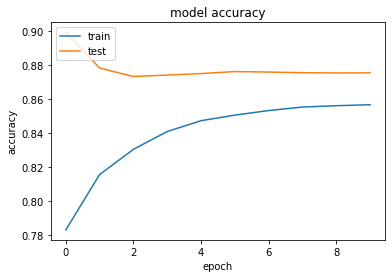

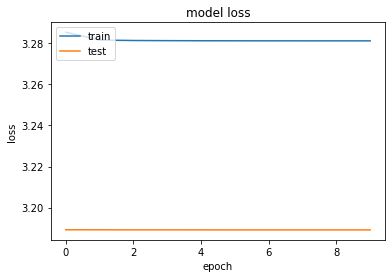

In [12]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Compute other metrics (to be checked)

In [13]:
from sklearn.metrics import classification_report

y_pred = model.predict(x_test, batch_size=2, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

676/676 [==============================] - 10s 15ms/step


ValueError: Classification metrics can't handle a mix of unknown and multiclass-multioutput targets

In [49]:
import pkgutil
list(pkgutil.iter_modules())


[ModuleInfo(module_finder=FileFinder('E:\\Xception'), name='mel_spectrogram_daniele', ispkg=False),
 ModuleInfo(module_finder=FileFinder('E:\\anaconda3\\envs\\plaidML\\DLLs'), name='_asyncio', ispkg=False),
 ModuleInfo(module_finder=FileFinder('E:\\anaconda3\\envs\\plaidML\\DLLs'), name='_bz2', ispkg=False),
 ModuleInfo(module_finder=FileFinder('E:\\anaconda3\\envs\\plaidML\\DLLs'), name='_ctypes', ispkg=False),
 ModuleInfo(module_finder=FileFinder('E:\\anaconda3\\envs\\plaidML\\DLLs'), name='_ctypes_test', ispkg=False),
 ModuleInfo(module_finder=FileFinder('E:\\anaconda3\\envs\\plaidML\\DLLs'), name='_decimal', ispkg=False),
 ModuleInfo(module_finder=FileFinder('E:\\anaconda3\\envs\\plaidML\\DLLs'), name='_elementtree', ispkg=False),
 ModuleInfo(module_finder=FileFinder('E:\\anaconda3\\envs\\plaidML\\DLLs'), name='_hashlib', ispkg=False),
 ModuleInfo(module_finder=FileFinder('E:\\anaconda3\\envs\\plaidML\\DLLs'), name='_lzma', ispkg=False),
 ModuleInfo(module_finder=FileFinder('E:\\an